<a href="https://colab.research.google.com/github/DamienSmith/UTS_ML2019_ID13039957/blob/master/A2_PracticalProject_13039957_13026998.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# A2: Practical Machine Learning Project | 31005 | Advanced Data Analytics
Student: 13039957 & 13026998

Link to Github:
https://github.com/DamienSmith/UTS_ML2019_ID13039957/blob/master/A2_PracticalProject_13039957_13026998.ipynb

##Introduction (100)

Project overview.

**Discuss the Algorithm** 
* Linear regression or decision tree

**Define Input/Output** 
* What data you use and what you’re getting out
* the format of the I/O data

##Exploration (300)

**Identify Challenges**

* Highlight the practical significance of the project
* What problems exist and how to manage them
  * e.g. memory management, time efficiency, 'advanced functions' (eg parallelism) 

**Design Data Structures**

* Design/planning of research/development is clear and logical
* Cover these:
  * data acquisition
  * quality control
  * modelling technicques
  * evaluation method & criteria

**Plan Data Models and Tests**

* Logical design (correct, efficient and practically complete)
* Evaluation method/Testing (Compare and consider alternatives)
* Must be able to run code through collab 
  * i.e. data load and python libraries need to work in Collab


**Possible alternatives**

* Algorithm Tuning. The application of CART to the Bank Note dataset was not tuned. Experiment with different parameter values and see if you can achieve better performance.

* Cross Entropy. Another cost function for evaluating splits is cross entropy (logloss). You could implement and experiment with this alternative cost function.

* Tree Pruning. An important technique for reducing overfitting of the training dataset is to prune the trees. Investigate and implement tree pruning methods.

* Categorical Dataset. The example was designed for input data with numerical or ordinal input attributes, experiment with categorical input data and splits that may use equality instead of ranking.

* Regression. Adapt the tree for regression using a different cost function and method for creating terminal nodes.

* More Datasets. Apply the algorithm to more datasets on the UCI Machine Learning Repository.



There several choices there is historically ID3 the Iterative Dichotomiser 3, C5 which I believe stands for Classifier as development of ID3. CART, which is for classification and regression tree. It's very common in Universal Choice. CHAID, which is for CHi-squared Automatic Interaction Detectior. MARS, which is multivariate adaptive regression splines. And the one that I'm going to be using Conditional Inference trees. Now decision trees in general have some pros and cons.



##Methodology (100 ex comments)

[code here]

**Build and Train Data Models**

* Comments connect the code to the algorithm steps
* 

## Decision Tree Model

In [22]:
## 
##    A2: Practical Machine Learning Project | 31005 | Advanced Data Analytics
##    
##    Authors: Rae Ho (13026998) & Damien Smith (13039957)
##    Goals: - Implement Decision Tree Algorithm
##           - Build & Train a model
##           - Explore/Compare alternative options within the algorithm
##    Code: Python 3
##    Github: https://github.com/DamienSmith/UTS_ML2019_ID13039957/blob/master/A2_PracticalProject_13039957_13026998.ipynb
##
##

# Import Libraries
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pandas_profiling as pp

# Load Data
# Just some test data
dataset = [[2.771244718,1.784783929,0],
	[1.728571309,1.169761413,0],
	[3.678319846,2.81281357,0],
	[3.961043357,2.61995032,0],
	[2.999208922,2.209014212,0],
	[7.497545867,3.162953546,1],
	[9.00220326,3.339047188,1],
	[7.444542326,0.476683375,1],
	[10.12493903,3.234550982,1],
	[6.642287351,3.319983761,1]]

dataset

# Get dataset
url = 'https://raw.githubusercontent.com/DamienSmith/UTS_ML2019_ID13039957/master/characters.csv'
df = pd.read_csv(url)

#Data profiling
pp.ProfileReport(df)

Number of variables,10
Number of observations,87
Total Missing (%),12.3%
Total size in memory,6.9 KiB
Average record size in memory,80.9 B
Numeric,1
Categorical,8
Boolean,0
Date,0
Text (Unique),1
Rejected,0


In [0]:
# Define Gini_index() Function 
# Calculate the Gini index for a split dataset

def gini_index(groups, classes):
	# count all samples at split point
	n_instances = float(sum([len(group) for group in groups]))
	# sum weighted Gini index for each group
	gini = 0.0
	for group in groups:
		size = float(len(group))
		# avoid divide by zero
		if size == 0:
			continue
		score = 0.0
		# score the group based on the score for each class
		for class_val in classes:
			p = [row[-1] for row in group].count(class_val) / size
			score += p * p
		# weight the group score by its relative size
		gini += (1.0 - score) * (size / n_instances)
	return gini


In [0]:
# Define worst_gini_index_test() Function
# Test on worst-case where there is a 50/50 split on each group
# For a comparison

def worst_gini_index_test(groups, classes):
	# count all samples at split point
	n_instances = float(sum([len(group) for group in groups]))
	# sum weighted Gini index for each group
	gini = 0.0
	for group in groups:
		size = float(len(group))
		# avoid divide by zero
		if size == 0:
			continue
		score = 0.0
		# score the group based on the score for each class
		for class_val in classes:
			p = [row[-1] for row in group].count(class_val) / size
			score += p * p
		# weight the group score by its relative size
		gini += (1.0 - score) * (size / n_instances)
	return gini
 
# test Gini values
print(gini_index([[[1, 1], [1, 0]], [[1, 1], [1, 0]]], [0, 1]))
print(gini_index([[[1, 0], [1, 0]], [[1, 1], [1, 1]]], [0, 1]))


0.5
0.0


In [0]:
# Define test_split() Function.
# Separate the dataset into two lists of rows given the index of an attribute and a split value for that attribute.
# Once we have the two groups, we can then use our Gini score above to evaluate the cost of the split.
# Note: The right group contains all rows with a value at the index above or equal to the split value.

# Split a dataset based on an attribute and an attribute value
def test_split(index, value, dataset):
	left, right = list(), list()
	for row in dataset:
		if row[index] < value:
			left.append(row)
		else:
			right.append(row)
	return left, right


# Splitting a dataset involves iterating over each row, checking if the attribute value is below or above the split value and assigning it to the left or right group respectively.

In [0]:
# Define get_split() Function.
# With the Gini function above and the test split function we now have everything we need to evaluate splits.
# Given a dataset, we must check every value on each attribute as a candidate split, evaluate the cost of the split and find the best possible split we could make.
# Once the best split is found, we can use it as a node in our decision tree

def get_split(dataset):
	class_values = list(set(row[-1] for row in dataset))
	b_index, b_value, b_score, b_groups = 999, 999, 999, None
	for index in range(len(dataset[0])-1):
		for row in dataset:
			groups = test_split(index, row[index], dataset)
			gini = gini_index(groups, class_values)
			print('X%d < %.3f Gini=%.3f' % ((index+1), row[index], gini))
			if gini < b_score:
				b_index, b_value, b_score, b_groups = index, row[index], gini, groups
	return {'index':b_index, 'value':b_value, 'groups':b_groups}

In [0]:
# Calculate the Gini index for a split dataset
def gini_index(groups, classes):
	# count all samples at split point
	n_instances = float(sum([len(group) for group in groups]))
	# sum weighted Gini index for each group
	gini = 0.0
	for group in groups:
		size = float(len(group))
		# avoid divide by zero
		if size == 0:
			continue
		score = 0.0
		# score the group based on the score for each class
		for class_val in classes:
			p = [row[-1] for row in group].count(class_val) / size
			score += p * p
		# weight the group score by its relative size
		gini += (1.0 - score) * (size / n_instances)
	return gini

# Split a dataset based on an attribute and an attribute value
def test_split(index, value, dataset):
	left, right = list(), list()
	for row in dataset:
		if row[index] < value:
			left.append(row)
		else:
			right.append(row)
	return left, right

# Select the best split point for a dataset
def get_split(dataset):
	class_values = list(set(row[-1] for row in dataset))
	b_index, b_value, b_score, b_groups = 999, 999, 999, None
	for index in range(len(dataset[0])-1):
		for row in dataset:
			groups = test_split(index, row[index], dataset)
			gini = gini_index(groups, class_values)
			print('X%d < %.3f Gini=%.3f' % ((index+1), row[index], gini))
			if gini < b_score:
				b_index, b_value, b_score, b_groups = index, row[index], gini, groups
	return {'index':b_index, 'value':b_value, 'groups':b_groups}
 
split = get_split(dataset)
print('Split: [X%d < %.3f]' % ((split['index']+1), split['value']))

X1 < 2.771 Gini=0.444
X1 < 1.729 Gini=0.500
X1 < 3.678 Gini=0.286
X1 < 3.961 Gini=0.167
X1 < 2.999 Gini=0.375
X1 < 7.498 Gini=0.286
X1 < 9.002 Gini=0.375
X1 < 7.445 Gini=0.167
X1 < 10.125 Gini=0.444
X1 < 6.642 Gini=0.000
X2 < 1.785 Gini=0.500
X2 < 1.170 Gini=0.444
X2 < 2.813 Gini=0.320
X2 < 2.620 Gini=0.417
X2 < 2.209 Gini=0.476
X2 < 3.163 Gini=0.167
X2 < 3.339 Gini=0.444
X2 < 0.477 Gini=0.500
X2 < 3.235 Gini=0.286
X2 < 3.320 Gini=0.375
Split: [X1 < 6.642]


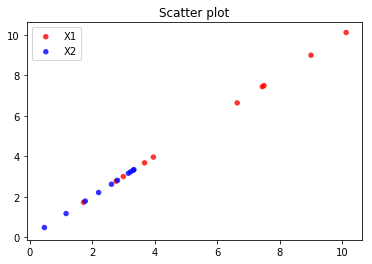

In [0]:
# plot scatter plot - needs work
x = [row[0] for row in dataset]
y = [row[1] for row in dataset]

data = x,y
colors = ("red", "blue")
groups = ("X1", "X2")

# Create plot
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)

for data, color, group in zip(data, colors, groups):
  x = data
  y = data
  ax.scatter(x, y, alpha=0.8, c=color, edgecolors='none', s=30, label=group)

plt.title('Scatter plot')
plt.legend(loc=2)
plt.show()

In [0]:
# We need to control the size of a tree by defining the depth and the number of rows that a node will run.

# We use user-defined arguments to define tree building procedure.
# Maximum Tree Depth. This is the maximum number of nodes from the root node of the tree. Once a maximum depth of the tree is met, we must stop splitting adding new nodes. Deeper trees are more complex and are more likely to overfit the training data.
# Minimum Node Records. This is the minimum number of training patterns that a given node is responsible for. Once at or below this minimum, we must stop splitting and adding new nodes. Nodes that account for too few training patterns are expected to be too specific and are likely to overfit the training data.

# There is one more condition. It is possible to choose a split in which all rows belong to one group. In this case, we will be unable to continue splitting and adding child nodes as we will have no records to split on one side or another.

# Now we have some ideas of when to stop growing the tree. When we do stop growing at a given point, that node is called a terminal node and is used to make a final prediction.

# This is done by taking the group of rows assigned to that node and selecting the most common class value in the group. This will be used to make predictions.


# Define to_terminal() Function
# Select a class value for a group of rows. It returns the most common output value in a list of rows.
def to_terminal(group):
	outcomes = [row[-1] for row in group]
	return max(set(outcomes), key=outcomes.count)

In [0]:
# # Split a dataset based on an attribute and an attribute value
def test_split(index, value, dataset):
	left, right = list(), list()
	for row in dataset:
		if row[index] < value:
			left.append(row)
		else:
			right.append(row)
	return left, right
 
# Calculate the Gini index for a split dataset
def gini_index(groups, classes):
	# count all samples at split point
	n_instances = float(sum([len(group) for group in groups]))
	# sum weighted Gini index for each group
	gini = 0.0
	for group in groups:
		size = float(len(group))
		# avoid divide by zero
		if size == 0:
			continue
		score = 0.0
		# score the group based on the score for each class
		for class_val in classes:
			p = [row[-1] for row in group].count(class_val) / size
			score += p * p
		# weight the group score by its relative size
		gini += (1.0 - score) * (size / n_instances)
	return gini
 
# Select the best split point for a dataset
def get_split(dataset):
	class_values = list(set(row[-1] for row in dataset))
	b_index, b_value, b_score, b_groups = 999, 999, 999, None
	for index in range(len(dataset[0])-1):
		for row in dataset:
			groups = test_split(index, row[index], dataset)
			gini = gini_index(groups, class_values)
			if gini < b_score:
				b_index, b_value, b_score, b_groups = index, row[index], gini, groups
	return {'index':b_index, 'value':b_value, 'groups':b_groups}
 
# Create a terminal node value
def to_terminal(group):
	outcomes = [row[-1] for row in group]
	return max(set(outcomes), key=outcomes.count)
 
# Create child splits for a node or make terminal
def split(node, max_depth, min_size, depth):
	left, right = node['groups']
	del(node['groups'])
	# check for a no split
	if not left or not right:
		node['left'] = node['right'] = to_terminal(left + right)
		return
	# check for max depth
	if depth >= max_depth:
		node['left'], node['right'] = to_terminal(left), to_terminal(right)
		return
	# process left child
	if len(left) <= min_size:
		node['left'] = to_terminal(left)
	else:
		node['left'] = get_split(left)
		split(node['left'], max_depth, min_size, depth+1)
	# process right child
	if len(right) <= min_size:
		node['right'] = to_terminal(right)
	else:
		node['right'] = get_split(right)
		split(node['right'], max_depth, min_size, depth+1)
    
# Build a decision tree
def build_tree(train, max_depth, min_size):
	root = get_split(train)
	split(root, max_depth, min_size, 1)
	return root
 
# Print a decision tree
def print_tree(node, depth=0):
	if isinstance(node, dict):
		print('%s[X%d < %.3f]' % ((depth*' ', (node['index']+1), node['value'])))
		print_tree(node['left'], depth+1)
		print_tree(node['right'], depth+1)
	else:
		print('%s[%s]' % ((depth*' ', node)))

tree = build_tree(dataset, 1, 1)
print_tree(tree)

[X1 < 6.642]
 [0]
 [1]


In [0]:
## show some experimenting with different 'max depth' parameters

##

##



In [0]:
# Make a prediction with a decision tree
def predict(node, row):
	if row[node['index']] < node['value']:
		if isinstance(node['left'], dict):
			return predict(node['left'], row)
		else:
			return node['left']
	else:
		if isinstance(node['right'], dict):
			return predict(node['right'], row)
		else:
			return node['right']
    
#  predict with a stump
stump = {'index': 0, 'right': 1, 'value': 6.642287351, 'left': 0}
for row in dataset:
	prediction = predict(stump, row)
	print('Predicted=%d, Result=%d' % (row[-1], prediction))

Predicted=0, Result=0
Predicted=0, Result=0
Predicted=0, Result=0
Predicted=0, Result=0
Predicted=0, Result=0
Predicted=1, Result=1
Predicted=1, Result=1
Predicted=1, Result=1
Predicted=1, Result=1
Predicted=1, Result=1


In [0]:
## Comparisons

## Regression?


## Linear Regression Model

In [0]:
#import libraries
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from math import sqrt

#dataset = pd.read_csv('dataset.csv')
dataset = [[2.771244718,1.784783929,0],
	[1.728571309,1.169761413,0],
	[3.678319846,2.81281357,0],
	[3.961043357,2.61995032,0],
	[2.999208922,2.209014212,0],
	[7.497545867,3.162953546,1],
	[9.00220326,3.339047188,1],
	[7.444542326,0.476683375,1],
	[10.12493903,3.234550982,1],
	[6.642287351,3.319983761,1]]

dataset
# print(dataset.shape)

# dataset.head()

[[2.771244718, 1.784783929, 0],
 [1.728571309, 1.169761413, 0],
 [3.678319846, 2.81281357, 0],
 [3.961043357, 2.61995032, 0],
 [2.999208922, 2.209014212, 0],
 [7.497545867, 3.162953546, 1],
 [9.00220326, 3.339047188, 1],
 [7.444542326, 0.476683375, 1],
 [10.12493903, 3.234550982, 1],
 [6.642287351, 3.319983761, 1]]

In [0]:
# Define Calculation Functions

# Calculate the mean value of a list of numbers
def mean(values):
	return sum(values) / float(len(values))
 
# Calculate covariance between x and y
def covariance(x, mean_x, y, mean_y):
	covar = 0.0
	for i in range(len(x)):
		covar += (x[i] - mean_x) * (y[i] - mean_y)
	return covar
 
# Calculate the variance of a list of numbers
def variance(values, mean):
	return sum([(x-mean)**2 for x in values])
 
# Calculate coefficients
def coefficients(dataset):
	x = [row[0] for row in dataset]
	y = [row[1] for row in dataset]
	x_mean, y_mean = mean(x), mean(y)
	b1 = covariance(x, x_mean, y, y_mean) / variance(x, x_mean)
	b0 = y_mean - b1 * x_mean
	return [b0, b1]


[1.9821291584841791, 1.8224808232595313, 2.1210154414361635, 2.1643044881025655, 2.017033765569457, 2.705794021992931, 2.936178767400693, 2.697678415506162, 3.108085804667108, 2.57484160958121]
RMSE: 1.923


In [0]:
# Calculate root mean squared error
def rmse_metric(actual, predicted):
	sum_error = 0.0
	for i in range(len(actual)):
		prediction_error = predicted[i] - actual[i]
		sum_error += (prediction_error ** 2)
	mean_error = sum_error / float(len(actual))
	return sqrt(mean_error)

In [0]:
# Evaluate regression algorithm on training dataset
def evaluate_algorithm(dataset, algorithm):
	test_set = list()
	for row in dataset:
		row_copy = list(row)
		row_copy[-1] = None
		test_set.append(row_copy)
	predicted = algorithm(dataset, test_set)
	print(predicted)
	actual = [row[-1] for row in dataset]
	rmse = rmse_metric(actual, predicted)
	return rmse

In [0]:
# Simple linear regression algorithm
def simple_linear_regression(train, test):
	predictions = list()
	b0, b1 = coefficients(train)
	for row in test:
		yhat = b0 + b1 * row[0]
		predictions.append(yhat)
	return predictions
 


In [0]:
# Test simple linear regression
rmse = evaluate_algorithm(dataset, simple_linear_regression)
print('RMSE: %.3f' % (rmse))

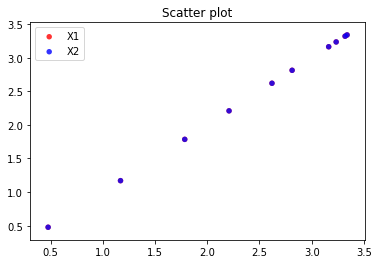

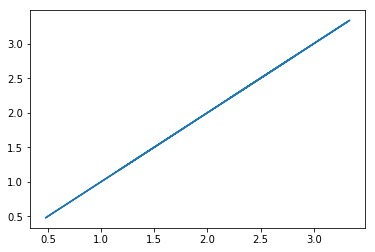

In [0]:
# Plotting - needs work

data = x,y
colors = ("red", "blue")
groups = ("X1", "X2")

# Create plot
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)

for data, color, group in zip(data, colors, groups):
  x = data
  y = data
  ax.scatter(x, y, alpha=0.8, c=color, edgecolors='none', s=30, label=group)

plt.title('Scatter plot')
plt.legend(loc=2)
plt.show()


plt.plot(x, y)
plt.show()

In [0]:
## Show comparison with a Large/small dataset

## Show comparison of predictive accuracy between Decision Tree & Linear Regression

##Evaluation (200)


**Report Execution on Data**

**Report Testing**

**Efficiency Analysis**

**Comparative Study**

ideas:
* how does each feature distribution look like? Are there any differences between feature distribution in train and test data?
* are there any meaningful interactions between the features?
* are there outliers and can they be explained?
* are there missing values or duplicates? What are reasons for them?


## Conclusion (100)


Discuss Reflections

Propose Possible Improvements



## Ethical (200)

* Discuss the social/ethical aspect of the project
  * adopt an ethical model (e.g. Ultitarian or Kantian)
* Consider how the technique could be misused

## Video Pitch

[url to video]

**Highlight Challenges and Effort**

* Describe challenges and how the team addressed them.